# Adversarial Attack

We are preloading a vision transformer.

In [ ]:
import numpy as np
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

def load_model_and_image():
    """Load a pre-trained ViT model and a sample image."""
    # Load the model
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

    # Load a sample image
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    raw_image = Image.open(requests.get(url, stream=True).raw)
    image = torch.tensor(np.array(raw_image)).permute(2, 0, 1)

    return processor, model, image

load_model_and_image()


## Classify Image

In [ ]:
"""
Classify an image using the ViT model.

Args:
    processor: ViT image processor
    model: ViT classification model
    image: Image tensor in CHW format

Returns:
    predicted_class_idx: Index of predicted class
    predicted_class_name: Name of predicted class
"""
def classify_image(processor, model, image):
    # - Use processor to prepare inputs
    #   - The processor takes in the image and returns a tensor with normalized pixel values that the model was trained on
    #   - It also crops/resizes the image to the expected input size
    inputs = processor(images=image, return_tensors="pt")
    # - Run the model to get logits
    outputs = model(**inputs)
    # - Find and return the predicted class index and name
    logits = outputs.logits
    # returns index of max value: logits.argmax(-1)
    predicted_class_idx = logits.argmax(-1).item()

    return predicted_class_idx, model.config.id2label[predicted_class_idx]


processor, model, image = load_model_and_image()
class_idx, class_name = classify_image(processor, model, image)

plt.figure(figsize=(8, 6))
plt.imshow(image.numpy().transpose(1, 2, 0).astype("uint8"))
plt.title(f"Predicted class: {class_name}")
plt.axis("off")
plt.show()

# Noise

Add noise to the image and see how it affects the model's prediction.

In [ ]:
processor, model, image = load_model_and_image()

noise = torch.randn_like(image, dtype=torch.float32) * 100
attack = torch.clip(image + noise.int(), 0, 255)

class_idx, class_name = classify_image(processor, model, attack)

plt.figure(figsize=(8, 6))
plt.imshow(attack.numpy().transpose(1, 2, 0).astype("uint8"))
plt.title(f"Predicted class: {class_name}")
plt.axis("off")
plt.show()

# Adversarial perturbation

Adversarial pertubation is noise that intends to misclassify an imgage to a specific class. 

In [ ]:
import tqdm

def create_adversarial_perturbation(processor, model, image, target_class_id, steps=10, lr=0.1):
    """
    Create an adversarial perturbation to make the model classify the image as target_class.

    Args:
        processor: ViT image processor
        model: ViT classification model
        image: Original image tensor
        target_class_id: Target class index
        steps: Number of optimization steps
        lr: Learning rate

    Returns:
        perturbation: The adversarial perturbation
        perturbed_image: The adversarially perturbed image
        success: Whether the attack succeeded (the target class was predicted)
    """
    # TODO: Implement adversarial perturbation generation
    # - Initialize a random perturbation with requires_grad=True
    # - Use an optimizer to update the perturbation
    # - Minimize cross-entropy loss with target class
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs["pixel_values"]

    # convert to dictionary for adam
    perturbation = torch.randn_like(inputs, dtype=torch.float32) * 0.00005
    perturbation = perturbation.requires_grad_(True)
    optimizer = torch.optim.Adam([perturbation], lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Test adversarial attack
    target_class = "daisy"
    target_class_id = model.config.label2id[target_class]
    y = torch.tensor([target_class_id])

    success = False
    for i in tqdm.tqdm(range(steps)):
        attack = torch.clip(inputs + perturbation, -1, 1)
        # - Run the model to get logits
        outputs = model(pixel_values=attack)

        loss = loss_fn(outputs.logits, y)

        # Get the predicted class ID from the logits
        current_pred_id = outputs.logits.argmax(-1).item()

        # Check if the prediction matches the target
        if current_pred_id == target_class_id:
            print(f"\n✅ Attack successful at step {i + 1}! Target class '{target_class}' was predicted.")
            success = True
            break  # Exit the loop early

            # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    perturbed_image = inputs + perturbation
    return perturbation.detach(), perturbed_image.detach(), success

target_class = "daisy"
target_class_id = model.config.label2id[target_class]

print(f"\nAttempting to change prediction to: {target_class}")
print("=" * 60)

perturbation, perturbed_image, success = create_adversarial_perturbation(
    processor, model, image, target_class_id, steps=10, lr=0.1
)

print(f"\nAttack {'succeeded' if success else 'failed'}!")

In [ ]:
# %%
# Visualize the original, perturbation, and perturbed image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image.numpy().transpose(1, 2, 0).astype("uint8"))
_, orig_class = classify_image(processor, model, image)
axes[0].set_title(f"Original: {orig_class}")
axes[0].axis("off")

# Perturbation (normalized for visualization)
pert_vis = perturbation.squeeze().permute(1, 2, 0).numpy()
# Normalize to [0, 1] for visualization
pert_vis = (pert_vis - pert_vis.min()) / (pert_vis.max() - pert_vis.min())
axes[1].imshow(pert_vis)
axes[1].set_title(f"Perturbation (L2: {perturbation.norm().item():.3f})")
axes[1].axis("off")

# Perturbed image
perturbed_vis = perturbed_image.squeeze().permute(1, 2, 0).numpy()
axes[2].imshow(perturbed_vis)
# Get prediction for perturbed image
outputs = model(pixel_values=perturbed_image)
pred_idx = outputs.logits.argmax(-1).item()
axes[2].set_title(f"Perturbed: {model.config.id2label[pred_idx]}")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# Constrained Adversarial Attack

In [ ]:
"""
    Create an adversarial perturbation, but add l2 and l∞ constraints.

    Args:
        processor: ViT image processor
        model: ViT classification model
        image: Original image tensor
        target_class_id: Target class index
        steps: Number of optimization steps
        lr: Learning rate
        l2_reg: L2 regularization strength
        l_inf_bound: Maximum allowed change per pixel (L∞ constraint)

    Returns:
        perturbation: The adversarial perturbation
        perturbed_image: The adversarially perturbed image
        success: Whether the attack succeeded
        history: Dictionary with loss and prediction history
    """
def create_constrained_adversarial_attack(
    processor, model, image, target_class_id, steps=20, lr=0.05, l2_reg=2.0, l_inf_bound=0.1
):  
    # - Track loss and predictions over time
    history = {}
    
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs["pixel_values"]

    # convert to dictionary for adam
    perturbation = torch.randn_like(inputs, dtype=torch.float32) * 0.05
    perturbation = perturbation.requires_grad_(True)

    optimizer = torch.optim.Adam([perturbation], lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Test adversarial attack
    target_class = "daisy"
    target_class_id = model.config.label2id[target_class]
    y = torch.tensor([target_class_id])

    success = False
    for i in tqdm.tqdm(range(steps)):

        # Apply perturbation with L∞ constraint
        clamped_perturbation = torch.clamp(perturbation, -l_inf_bound, l_inf_bound)

        attack = torch.clip(inputs + clamped_perturbation, -1, 1)
        # - Run the model to get logits
        outputs = model(pixel_values=attack)

        # - Add L2 regularization to the loss
        loss = loss_fn(outputs.logits, y) + (l2_reg * perturbation.norm())

        # Get the predicted class ID from the logits
        current_pred_id = outputs.logits.argmax(-1).item()

        # Check if the prediction matches the target
        if current_pred_id == target_class_id:
            print(f"\n✅ Attack successful at step {i + 1}! Target class '{target_class}' was predicted.")
            success = True
            break  # Exit the loop early

            # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        history[i] = {"loss": loss, "prediction": current_pred_id}

    perturbed_image = inputs + perturbation
    return perturbation.detach(), perturbed_image.detach(), success, history


# Test different regularization strengths
regularization_strengths = [0.5, 2.0, 5.0]
results = []

for l2_reg in regularization_strengths:
    print(f"\n{'=' * 60}")
    print(f"Testing L2 regularization strength: {l2_reg}")
    print(f"{'=' * 60}")

    pert, perturbed, success, history = create_constrained_adversarial_attack(
        processor, model, image, target_class_id, steps=30, lr=0.05, l2_reg=l2_reg, l_inf_bound=0.1
    )

    results.append(
        {
            "l2_reg": l2_reg,
            "perturbation": pert,
            "perturbed_image": perturbed,
            "success": success,
            "l2_norm": pert.norm().item(),
            "l_inf_norm": pert.abs().max().item(),
        }
    )


In [ ]:
# Visualize results for different regularization strengths
fig, axes = plt.subplots(len(results), 3, figsize=(12, 4 * len(results)))

for i, result in enumerate(results):
    # Original
    axes[i, 0].imshow(image.numpy().transpose(1, 2, 0).astype("uint8"))
    axes[i, 0].set_title(f"Original")
    axes[i, 0].axis("off")

    # Perturbation
    pert_vis = result["perturbation"].squeeze().permute(1, 2, 0).numpy()
    pert_vis = (pert_vis - pert_vis.min()) / (pert_vis.max() - pert_vis.min() + 1e-8)
    axes[i, 1].imshow(pert_vis)
    axes[i, 1].set_title(f"Perturbation (L2 reg={result['l2_reg']})")
    axes[i, 1].axis("off")

    # Perturbed
    perturbed_vis = result["perturbed_image"].squeeze().permute(1, 2, 0).numpy()
    axes[i, 2].imshow(perturbed_vis)

    # Get final prediction
    outputs = model(pixel_values=result["perturbed_image"])
    pred_idx = outputs.logits.argmax(-1).item()
    pred_class = model.config.id2label[pred_idx]

    status = "✓" if result["success"] else "✗"
    axes[i, 2].set_title(
        f"{status} Predicted: {pred_class}\nL2: {result['l2_norm']:.3f}, L∞: {result['l_inf_norm']:.3f}"
    )
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Summary statistics
print("\nAttack Summary:")
print("=" * 60)
for result in results:
    print(f"L2 Regularization: {result['l2_reg']}")
    print(f"  - Success: {'Yes' if result['success'] else 'No'}")
    print(f"  - L2 norm: {result['l2_norm']:.4f}")
    print(f"  - L∞ norm: {result['l_inf_norm']:.4f}")
    print()


# Watermarking in Diffusion Models

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import matplotlib.pyplot as plt
import numpy as np

# Move to appropriate device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

def setup_diffusion_pipeline():
    """Set up the Stable Diffusion pipeline."""
    pipe = StableDiffusionPipeline.from_pretrained("nota-ai/bk-sdm-v2-tiny", torch_dtype=torch.float16)

    # Move to appropriate device
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
    elif torch.backends.mps.is_available():
        pipe = pipe.to("mps")
    else:
        pipe = pipe.to("cpu")

    return pipe

"""
Generate an image with the sd model.

Args:
    pipe: Stable Diffusion pipeline
    prompt: Text prompt for generation
    seed: Random seed for reproducibility
    steps: Number of inference steps

Returns:
    image: Generated PIL image
"""
def generate_baseline_image(pipe, prompt, seed=0, steps=5):
    generator=torch.Generator(device=device).manual_seed(seed)
    image = pipe(prompt, generator=generator).images[0]
    return image

# Set up and test
pipe = setup_diffusion_pipeline()
prompt = "a tabby cat in a trench coat"
baseline_image = generate_baseline_image(pipe, prompt)

baseline_image.save("baseline_image.png")
# Display the baseline image
plt.figure(figsize=(8, 8))
plt.imshow(np.array(baseline_image))
plt.title("Baseline Image (No Watermark)")
plt.axis('off')
plt.show()

# Save for comparison
# baseline_image

We are implementing watermarking by modifying the UNet's output in the frequency domain.

100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


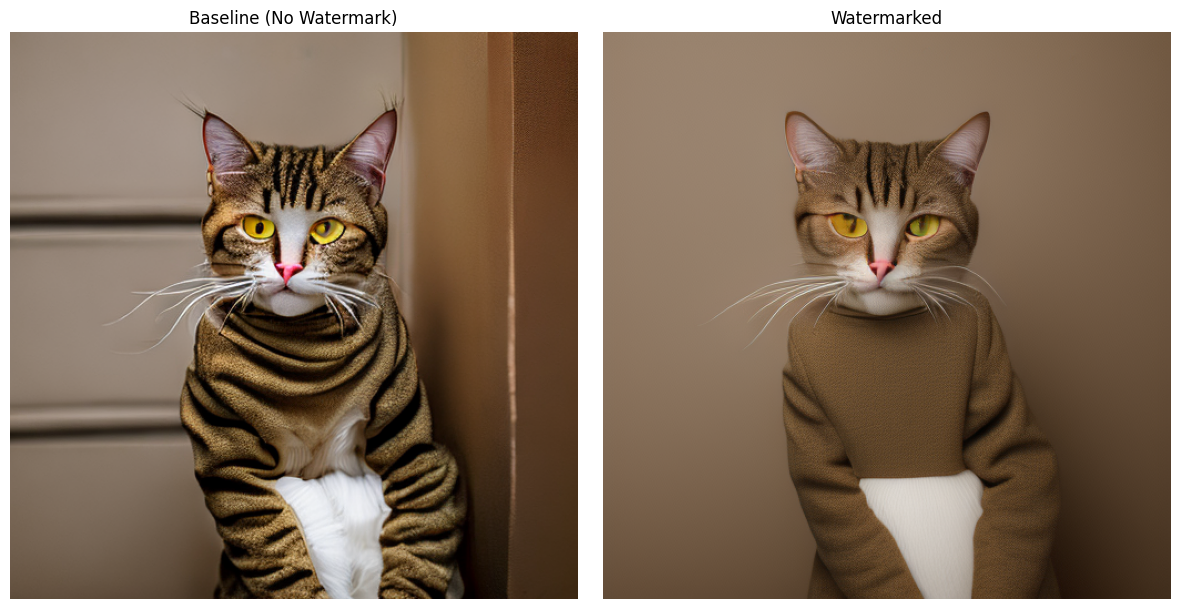

In [97]:

class FrequencyWatermarker:
    """Watermarker that modifies specific frequency bands in UNet outputs."""

    def __init__(self):
        """
        Initialize the watermarker.
        """
        self.hook_handle = None

    def watermark_hook(self, module, input, output):
        """
        Hook function that modifies UNet output in frequency domain.

        This function is called during the forward pass of the UNet.
        """
        # Extract the output tensor to modify (second channel)
        to_update = output[0][0].to(dtype=torch.float32)

        # Convert to frequency domain
        fft_output = torch.fft.fft2(to_update)
        fft_shifted = torch.fft.fftshift(fft_output, dim=(-2, -1))

        # Modify specific frequency band
        start, end = (10, 40)
        fft_shifted[:, start:end, :] *= 0.99
        fft_shifted[:, :, start:end] *= 0.99

        # # Modify specific frequency band
        # start, end = (30,50)
        # fft_shifted[:, start:end, :] *= 0.99

        # Convert back to spatial domain
        fft_unshifted = torch.fft.ifftshift(fft_shifted, dim=(-2, -1))
        spatial_output = torch.fft.ifft2(fft_unshifted)

        # Update the output
        output[0][0] = spatial_output.real

        return output


    def attach(self, unet):
        self.hook_handle = unet.register_forward_hook(self.watermark_hook)

    def detach(self):
        if self.hook_handle:
            self.hook_handle.remove()
            self.hook_handle = None

def generate_watermarked_image(pipe, prompt, watermarker, seed=0, steps=5):
    """Generate an image with watermarking applied."""
    # Extract UNet from pipeline
    unet = pipe.components['unet']

    # Attach watermarker
    watermarker.attach(unet)

    try:
        # Generate image
        device = pipe.device.type
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe(prompt, generator=generator).images[0]
    finally:
        # Always detach the watermarker
        watermarker.detach()

    return image

# Test watermarking
watermarker = FrequencyWatermarker()
watermarked_image = generate_watermarked_image(pipe, prompt, watermarker)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(np.array(baseline_image))
axes[0].set_title("Baseline (No Watermark)")
axes[0].axis('off')

axes[1].imshow(np.array(watermarked_image))
axes[1].set_title("Watermarked")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save watermarked image
watermarked_image.save("watermarked_image.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..28.11986435867371].


Analyzing frequency domain differences...


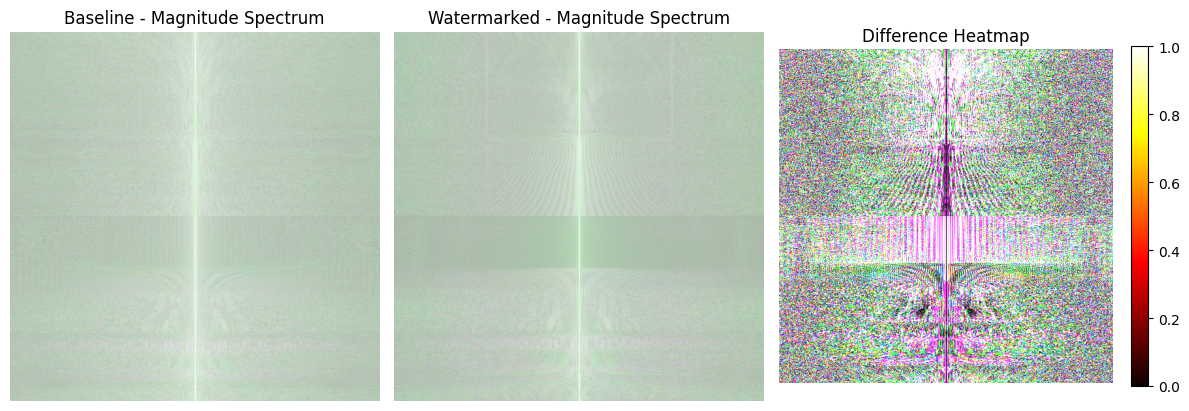


Watermark Analysis:
Maximum difference in frequency domain: 28.1199
Mean difference in frequency domain: 1.0000


In [98]:
def compute_fft_magnitude_spectrum(image):
    """
    Compute the magnitude spectrum of an image's FFT.

    Args:
        image: PIL Image or numpy array

    Returns:
        magnitude_spectrum: Log magnitude spectrum (in dB)
        fft_shifted: Shifted FFT for further analysis
    """
    pixels = np.asarray(image)
    fft_output = np.fft.fft2(pixels)
    fft_shifted = np.fft.fftshift(fft_output)
    # db = 20 * np.log10(np.maximum(np.sqrt(np.sum(np.power(np.abs(fft_shifted), 2), axis=-1)), 1e-10))
    db = 20 * np.log(np.abs(fft_shifted) + 1e-8)
    return db, fft_shifted


def visualize_frequency_comparison(baseline_image, watermarked_image):
    """Visualize and compare frequency domains of baseline and watermarked images."""
    # Compute FFT for both images
    mag_baseline, fft_baseline = compute_fft_magnitude_spectrum(baseline_image)
    mag_watermarked, fft_watermarked = compute_fft_magnitude_spectrum(watermarked_image)

    # Normalize for visualization
    min_mag = min(mag_baseline.min(), mag_watermarked.min())
    max_mag = max(mag_baseline.max(), mag_watermarked.max())

    mag_baseline_norm = (mag_baseline - min_mag) / (max_mag - min_mag)
    mag_watermarked_norm = (mag_watermarked - min_mag) / (max_mag - min_mag)

    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 10))

    # Magnitude spectra
    axes[0].imshow(mag_baseline_norm, cmap='gray')
    axes[0].set_title('Baseline - Magnitude Spectrum')
    axes[0].axis('off')

    axes[1].imshow(mag_watermarked_norm, cmap='gray')
    axes[1].set_title('Watermarked - Magnitude Spectrum')
    axes[1].axis('off')

    # Difference heatmap
    magnitude_diff = np.abs(mag_baseline_norm - mag_watermarked_norm)
    magnitude_diff = magnitude_diff / (magnitude_diff.mean() + 1e-8)  # Normalize

    im = axes[2].imshow(magnitude_diff, cmap='hot')
    axes[2].set_title('Difference Heatmap')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

    return magnitude_diff

# Analyze the watermark
print("Analyzing frequency domain differences...")
diff_map = visualize_frequency_comparison(baseline_image, watermarked_image)

# Print statistics
print(f"\nWatermark Analysis:")
print(f"Maximum difference in frequency domain: {diff_map.max():.4f}")
print(f"Mean difference in frequency domain: {diff_map.mean():.4f}")

Testing watermark robustness...


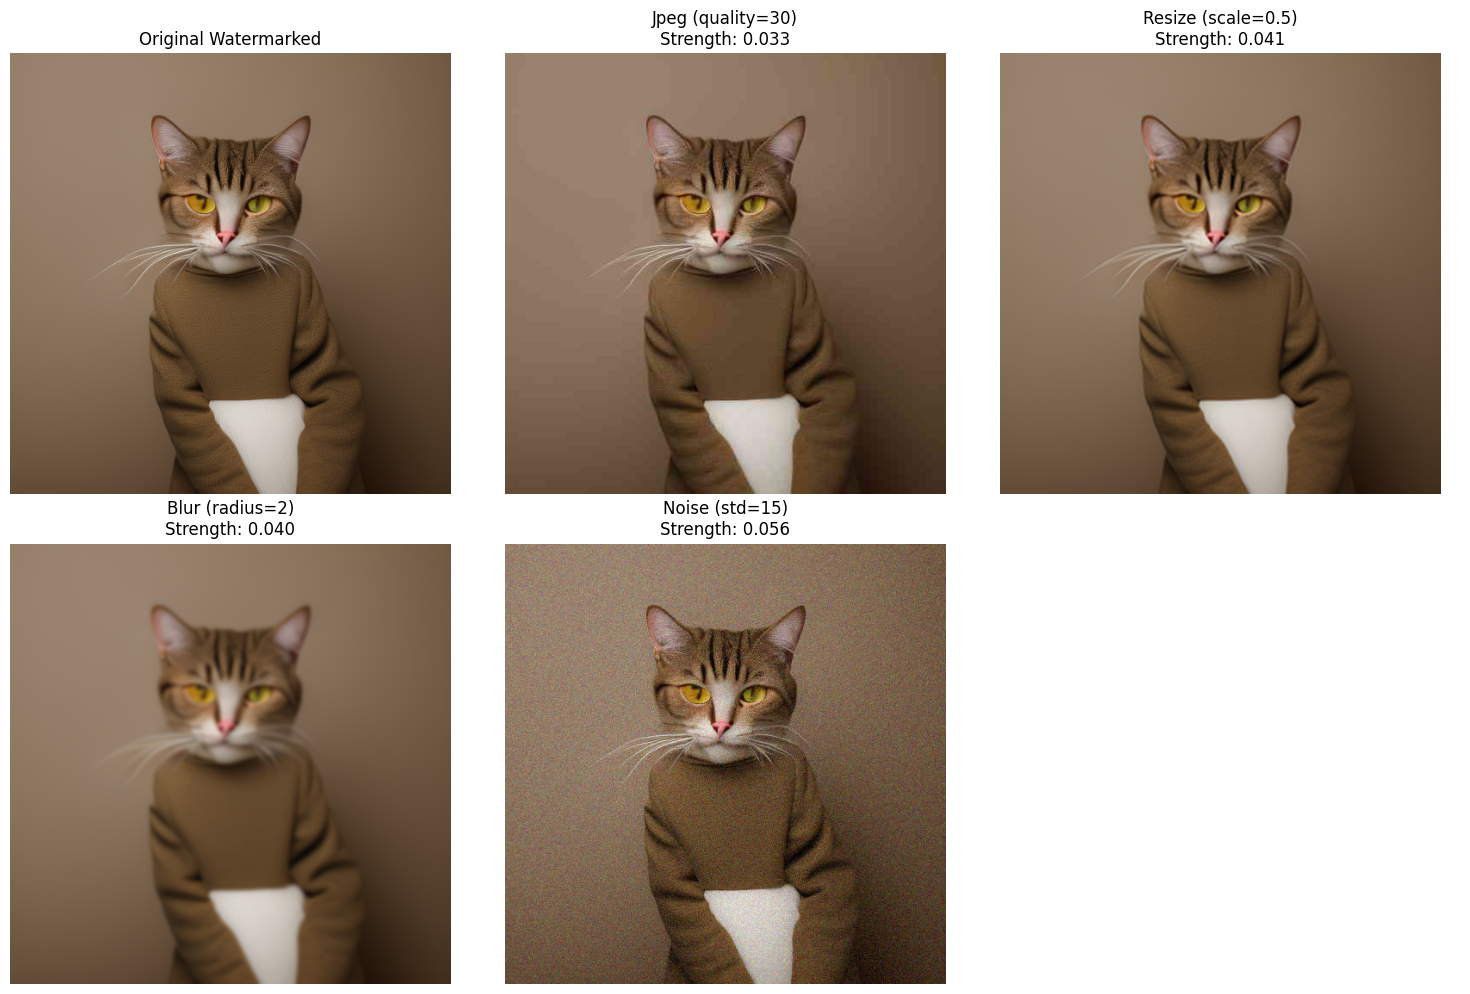


Robustness Summary:
Jpeg: strength = 0.0330
  ✓ Watermark detected
Resize: strength = 0.0409
  ✓ Watermark detected
Blur: strength = 0.0401
  ✓ Watermark detected
Noise: strength = 0.0557
  ✓ Watermark detected


In [99]:

from PIL import Image, ImageFilter
import io

def apply_image_transformation(image, transform_type, **kwargs):
    """
    Apply various transformations to test watermark robustness.

    Args:
        image: PIL Image
        transform_type: One of ['jpeg', 'resize', 'blur', 'noise']
        **kwargs: Additional parameters for the transformation

    Returns:
        transformed_image: Transformed PIL Image
    """
    if transform_type == 'jpeg':
        # JPEG compression
        quality = kwargs.get('quality', 50)
        buffer = io.BytesIO()
        image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        return Image.open(buffer)

    elif transform_type == 'resize':
        # Resize down and back up
        scale = kwargs.get('scale', 0.5)
        orig_size = image.size
        small_size = (int(orig_size[0] * scale), int(orig_size[1] * scale))
        return image.resize(small_size, Image.Resampling.LANCZOS).resize(orig_size, Image.Resampling.LANCZOS)

    elif transform_type == 'blur':
        # Gaussian blur
        radius = kwargs.get('radius', 2)
        return image.filter(ImageFilter.GaussianBlur(radius=radius))

    elif transform_type == 'noise':
        # Add Gaussian noise
        std = kwargs.get('std', 10)
        img_array = np.array(image).astype(float)
        noise = np.random.normal(0, std, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy)

def check_watermark_robustness(baseline_image, watermarked_image):
    """Test watermark detection after various transformations."""
    transformations = [
        ('jpeg', {'quality': 30}),
        ('resize', {'scale': 0.5}),
        ('blur', {'radius': 2}),
        ('noise', {'std': 15})
    ]

    results = []

    for transform_type, params in transformations:
        # Apply transformation to both images
        transformed_baseline = apply_image_transformation(baseline_image, transform_type, **params)
        transformed_watermarked = apply_image_transformation(watermarked_image, transform_type, **params)

        # Compute FFT difference
        mag_base, _ = compute_fft_magnitude_spectrum(transformed_baseline)
        mag_water, _ = compute_fft_magnitude_spectrum(transformed_watermarked)

        # Normalize and compute difference
        min_mag = min(mag_base.min(), mag_water.min())
        max_mag = max(mag_base.max(), mag_water.max())
        mag_base_norm = (mag_base - min_mag) / (max_mag - min_mag + 1e-8)
        mag_water_norm = (mag_water - min_mag) / (max_mag - min_mag + 1e-8)

        diff = np.abs(mag_base_norm - mag_water_norm)

        # Measure watermark strength in the target frequency band
        center = np.array(diff.shape) // 2
        y, x = np.ogrid[:diff.shape[0], :diff.shape[1]]

        # Create mask for frequency band 3-25
        dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        band_mask = (dist_from_center >= 3) & (dist_from_center <= 25)

        watermark_strength = diff[band_mask].mean() if band_mask.any() else 0

        results.append({
            'transform': transform_type,
            'params': params,
            'strength': watermark_strength,
            'transformed_image': transformed_watermarked
        })

    return results

# Test robustness
print("Testing watermark robustness...")
robustness_results = check_watermark_robustness(baseline_image, watermarked_image)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original watermarked image
axes[0].imshow(np.array(watermarked_image))
axes[0].set_title('Original Watermarked')
axes[0].axis('off')

# Transformed images
for i, result in enumerate(robustness_results):
    axes[i+1].imshow(np.array(result['transformed_image']))
    transform_name = f"{result['transform'].capitalize()}"
    param_str = ', '.join(f"{k}={v}" for k, v in result['params'].items())
    axes[i+1].set_title(f'{transform_name} ({param_str})\nStrength: {result["strength"]:.3f}')
    axes[i+1].axis('off')

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Summary
print("\nRobustness Summary:")
print("="*50)
for result in robustness_results:
    print(f"{result['transform'].capitalize()}: strength = {result['strength']:.4f}")
    if result['strength'] > 0.01:
        print("  ✓ Watermark detected")
    else:
        print("  ✗ Watermark lost")